In [325]:
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Import Data

In [326]:
train = pd.read_csv('/Users/dylanhayashi/Desktop/MSDS 422 - Practical Machine Learning/Data/allstate-claims-severity/train.csv')
test = pd.read_csv('/Users/dylanhayashi/Desktop/MSDS 422 - Practical Machine Learning/Data/allstate-claims-severity/test.csv')

### Missing Data

In [336]:
# Training Data
print(f'\nNumber of missing values in the training set: {train.isnull().sum().sum()}\nWonderful!')

# Test Data
print(f'\nNumber of missing values in the test set: {test.isnull().sum().sum()}\nWonderful!')


Number of missing values in the training set: 0
Wonderful!

Number of missing values in the test set: 0
Wonderful!


### Outliers

In [337]:
# Calculate range
mean = train.loc[:,'loss'].mean()
std_dev = train.loc[:,'loss'].std()
lower_limit = mean - (3 * std_dev)
upper_limit = mean + (3 * std_dev)

# Subset outliers
positive_outliers = train[train['loss'] > upper_limit]
negative_outliers = train[train['loss'] < lower_limit]

# Count
print(f'There are {len(positive_outliers)} positive outliers and {len(negative_outliers)} negative outliers.')
print('I will not be dropping outliers.')

There are 3524 positive outliers and 0 negative outliers.
I will not be dropping outliers.


### Target Variable: Loss

In [338]:
round(train.loc[:,'loss'].describe(),3)

count    188318.000
mean       3037.338
std        2904.086
min           0.670
25%        1204.460
50%        2115.570
75%        3864.045
max      121012.250
Name: loss, dtype: float64

In [339]:
y_train = train.loc[:,'loss']
x_train = train.drop(['loss'], axis = 1)
x_test = test

Loss Skew : 3.795
Loss Kurtosis : 48.08


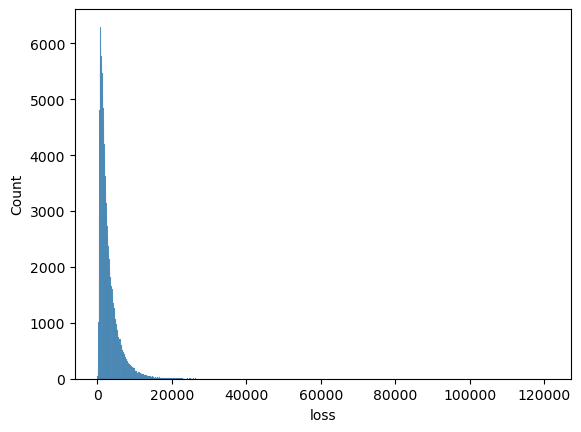

Loss is highly skewed and has high kurtosis.
Log transformation of loss improves that.

Log Loss Skew : 0.093
Log Loss Kurtosis : -0.115


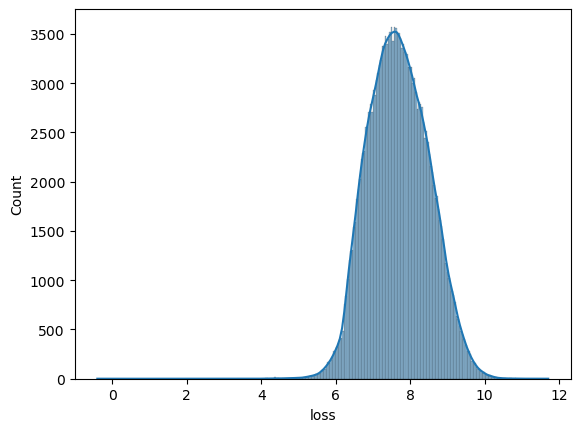

In [340]:
# Loss Skew/Kurtosis

# Skew / Kurtosis
loss = train.loc[:,'loss']
loss_skew = loss.skew()
loss_kurtosis = loss.kurtosis()
print(f'Loss Skew : {round(loss_skew,3)}')
print(f'Loss Kurtosis : {round(loss_kurtosis,3)}')

# Distplot
loss_histplot = sns.histplot(loss)
plt.show(loss_histplot)

# Log Loss
print('Loss is highly skewed and has high kurtosis.')
print('Log transformation of loss improves that.')

# Skew / Kurtosis
log_loss = np.log(loss)
log_loss_skew = log_loss.skew()
log_loss_kurtosis = log_loss.kurtosis()
print(f'\nLog Loss Skew : {round(log_loss_skew,3)}')
print(f'Log Loss Kurtosis : {round(log_loss_kurtosis,3)}')

# Distplot
log_loss_histplot = sns.histplot(log_loss, kde = True)
plt.show(log_loss_histplot)

### Continuous Variables

In [341]:
# Get continuous variable subset
continuous_variables = x_train.loc[:,x_train.columns[-14:]] 
corr_table = pd.DataFrame(columns = ['variable','corr'])

# Analyze variable correlation with loss
for each_variable in continuous_variables.columns:
    variable = continuous_variables.loc[:,each_variable]
    corr = round(variable.corr(y_train),3)
    var_row = pd.DataFrame({'variable' : [each_variable], 'corr':[corr]})
    corr_table = corr_table.append(var_row)
    corr_table = corr_table.sort_values(['corr'], ascending = False)

print('I will be using the 10 highest correlated continuous variables.')
display(corr_table[0:10])

I will be using the 10 highest correlated continuous variables.


,variable,corr
0,cont2,0.142
0,cont7,0.120
0,cont3,0.111
0,cont11,0.100
0,cont12,0.099
0,cont6,0.041
0,cont8,0.031
0,cont10,0.020
0,cont14,0.019
0,cont9,0.014



cont11 and cont12 look to be nearly perfectly correlated, I will drop cont12.


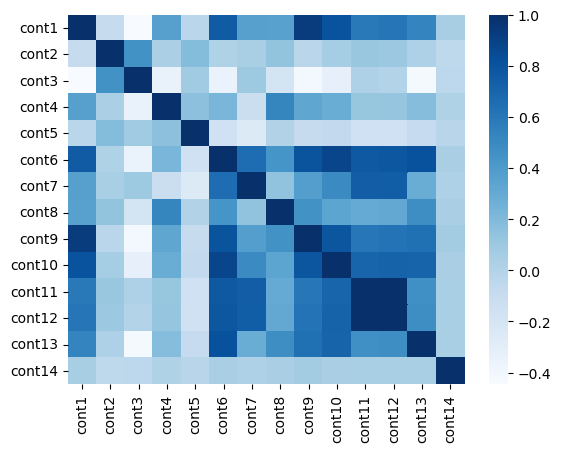

In [342]:
# Multi-Collinearity
sns.heatmap(continuous_variables.corr(), cmap="Blues")

print('\ncont11 and cont12 look to be nearly perfectly correlated, I will drop cont12.')
x_train_cont = continuous_variables.drop(['cont12'], axis = 1)
plt.show()

In [343]:
x_train_cont = pd.DataFrame()
for each_column in corr_table.loc[:,'variable'][0:10]:
    column = continuous_variables.loc[:,each_column]
    x_train_cont[each_column] = column
print('This is the continuous variable subset of my training set.')
display(x_train_cont.head())

This is the continuous variable subset of my training set.


,cont2,cont7,cont3,cont11,cont12,cont6,cont8,cont10,cont14,cont9
0,0.245921,0.335060,0.187583,0.569745,0.594646,0.718367,0.30260,0.83510,0.714843,0.67135
1,0.737068,0.436585,0.592681,0.338312,0.366307,0.438917,0.60087,0.43919,0.304496,0.35127
2,0.358319,0.315545,0.484196,0.381398,0.373424,0.289648,0.27320,0.32446,0.774425,0.26076
3,0.555782,0.391128,0.527991,0.327915,0.321570,0.440945,0.31796,0.44467,0.602642,0.32128
4,0.159990,0.247408,0.527991,0.204687,0.202213,0.178193,0.24564,0.21230,0.432606,0.22089


### Categorical Variables

In [344]:
# Create categorical variable subset
categorical_variables = x_train[x_train.columns[1:-14]]
display(categorical_variables.head())

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [345]:
# Credit for Idea: AABOYLES - https://www.kaggle.com/aaboyles/beginner-friendly-simple-linear-regression

# Encode categorical variables by replacing letters with the median loss of that class

encoded_categorical_variables = pd.DataFrame()

for each_column in categorical_variables.columns:
    alpha_values = pd.DataFrame({'id' : train.iloc[:,0]})
    alpha_values[each_column] = categorical_variables.loc[:,each_column]
    alpha_values = alpha_values.drop('id', axis = 1)
    new_values = pd.DataFrame(train['loss'].groupby(train[each_column]).median())
    alpha_values = alpha_values.merge(new_values, how = 'left', on = each_column)
    encoded_categorical_variables[each_column] = alpha_values.loc[:,'loss']
    
display(encoded_categorical_variables.head())

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,2458.69,2833.99,2033.38,2457.71,1947.07,2341.86,2073.635,2070.73,2856.755,1902.69,...,2103.270,2225.51,2054.755,1939.76,2063.98,2453.190,2000.620,2341.86,2076.660,2145.630
1,2458.69,2833.99,2033.38,1974.74,1947.07,2341.86,2073.635,2070.73,2856.755,4089.17,...,2038.555,2041.16,2141.130,1991.56,1974.74,1596.855,2029.090,2341.86,2076.660,2087.055
2,2458.69,2833.99,2033.38,1974.74,2464.84,2341.86,2073.635,2070.73,2856.755,4089.17,...,2098.485,2189.20,2048.220,2020.68,1974.74,2183.240,2144.610,2341.86,2021.910,2050.455
3,1444.86,2833.99,2033.38,2457.71,1947.07,2341.86,2073.635,2070.73,2856.755,1902.69,...,2038.555,2041.16,2141.130,2056.51,2063.98,2138.780,2045.145,2341.86,2076.660,2032.920
4,2458.69,2833.99,2033.38,2457.71,1947.07,2341.86,2073.635,2070.73,2856.755,4089.17,...,2233.975,2041.21,1965.400,1973.47,2063.98,2066.760,2029.090,2341.86,2099.265,2211.585


In [346]:
# Analyze correlations between categorical variables and loss using new quantitative values

corr_table = pd.DataFrame(columns = ['variable','corr'])
for each_variable in encoded_categorical_variables.columns:
    variable = encoded_categorical_variables.loc[:,each_variable]
    corr = round(variable.corr(y_train),3)
    var_row = pd.DataFrame({'variable' : [each_variable], 'corr':[corr]})
    corr_table = corr_table.append(var_row)
    corr_table = corr_table.sort_values(['corr'], ascending = False)
    
print('I will be using the 10 most highly correlated categorical variables.')
display(corr_table[0:10])

I will be using the 10 most highly correlated categorical variables.


,variable,corr
0,cat80,0.483
0,cat79,0.461
0,cat87,0.364
0,cat101,0.361
0,cat57,0.317
0,cat12,0.311
0,cat100,0.310
0,cat10,0.282
0,cat89,0.280
0,cat7,0.280


In [347]:
# Create x_train categorical variables by subsetting 
x_train_cat = pd.DataFrame()
for each_column in corr_table.loc[:,'variable'][0:10]:
    column = encoded_categorical_variables.loc[:,each_column]
    x_train_cat[each_column] = column
    
print('This is the categorical variable subset of my training set.')
x_train_cat.head()

This is the categorical variable subset of my training set.


,cat80,cat79,cat87,cat101,cat57,cat12,cat100,cat10,cat89,cat7
0,1695.59,1858.84,1934.57,2644.12,2081.93,1869.45,2310.510,1902.69,2073.635,2073.635
1,1695.59,1858.84,1934.57,2723.55,2081.93,1869.45,3315.150,4089.17,2073.635,2073.635
2,4568.17,1858.84,1934.57,5970.22,2081.93,4322.13,3315.150,4089.17,2073.635,2073.635
3,1695.59,1858.84,1934.57,1927.96,2081.93,1869.45,1470.680,1902.69,2073.635,2073.635
4,4568.17,5440.81,4967.84,3825.63,2081.93,4322.13,2325.085,4089.17,2073.635,2073.635


### Training Dataset Final Construction

In [350]:
x_train = pd.concat([x_train_cat, x_train_cont], axis = 'columns')
display(x_train.head())

,cat80,cat79,cat87,cat101,cat57,cat12,cat100,cat10,cat89,cat7,cont2,cont7,cont3,cont11,cont12,cont6,cont8,cont10,cont14,cont9
0,1695.59,1858.84,1934.57,2644.12,2081.93,1869.45,2310.510,1902.69,2073.635,2073.635,0.245921,0.335060,0.187583,0.569745,0.594646,0.718367,0.30260,0.83510,0.714843,0.67135
1,1695.59,1858.84,1934.57,2723.55,2081.93,1869.45,3315.150,4089.17,2073.635,2073.635,0.737068,0.436585,0.592681,0.338312,0.366307,0.438917,0.60087,0.43919,0.304496,0.35127
2,4568.17,1858.84,1934.57,5970.22,2081.93,4322.13,3315.150,4089.17,2073.635,2073.635,0.358319,0.315545,0.484196,0.381398,0.373424,0.289648,0.27320,0.32446,0.774425,0.26076
3,1695.59,1858.84,1934.57,1927.96,2081.93,1869.45,1470.680,1902.69,2073.635,2073.635,0.555782,0.391128,0.527991,0.327915,0.321570,0.440945,0.31796,0.44467,0.602642,0.32128
4,4568.17,5440.81,4967.84,3825.63,2081.93,4322.13,2325.085,4089.17,2073.635,2073.635,0.159990,0.247408,0.527991,0.204687,0.202213,0.178193,0.24564,0.21230,0.432606,0.22089


### Test Dataset Construction

In [351]:
# Continuous Variables
x_test_cont = test.loc[:,x_train_cont.columns]

# Categorical Variables
x_test_cat = test.loc[:,x_train_cat.columns]

# Encode
encoded_x_test_cat = pd.DataFrame()
for each_column in x_test_cat.columns:
    alpha_values = pd.DataFrame({'id' : test.iloc[:,0]})
    alpha_values[each_column] = x_test_cat.loc[:,each_column]
    alpha_values = alpha_values.drop('id', axis = 1)
    new_values = pd.DataFrame(train['loss'].groupby(train[each_column]).median())
    alpha_values = alpha_values.merge(new_values, how = 'left', on = each_column)
    encoded_x_test_cat[each_column] = alpha_values.loc[:,'loss']
x_test_cat = encoded_x_test_cat.fillna(0)

# Concatenate
x_test = pd.concat([x_test_cat, x_test_cont], axis = 'columns')
print('This is my final training set.')
display(x_test.head())

This is my final training set.


,cat80,cat79,cat87,cat101,cat57,cat12,cat100,cat10,cat89,cat7,cont2,cont7,cont3,cont11,cont12,cont6,cont8,cont10,cont14,cont9
0,1695.59,1858.84,1934.57,2644.120,2081.93,1869.45,2932.415,1902.69,2073.635,2073.635,0.299102,0.317681,0.246911,0.377724,0.369858,0.466591,0.61229,0.38016,0.392562,0.34365
1,1695.59,1858.84,1934.57,1927.960,2081.93,1869.45,2310.510,1902.69,2073.635,2073.635,0.620805,0.443760,0.654310,0.689039,0.675759,0.482425,0.71330,0.60401,0.208045,0.51890
2,4568.17,1858.84,1934.57,6016.505,9532.34,4322.13,3636.050,4089.17,7666.925,7614.575,0.737068,0.325779,0.711159,0.245410,0.241676,0.212308,0.29758,0.30529,0.297232,0.34365
3,4568.17,5440.81,5270.12,1739.250,2081.93,1869.45,3636.050,1902.69,2073.635,2073.635,0.681761,0.342355,0.592681,0.348867,0.341872,0.369930,0.40028,0.31480,0.555955,0.33237
4,1695.59,1858.84,1934.57,1739.250,2081.93,1869.45,1281.935,1902.69,2073.635,2073.635,0.299102,0.391833,0.263570,0.359572,0.352251,0.398862,0.23688,0.50556,0.825823,0.43731


### Model 1: Linear Regression - Normal Equation

In [352]:
# Create Model
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_train)

In [353]:
# Training Statistics
r2 = round(metrics.r2_score(y_train, y_pred),3)
mae = round(metrics.mean_absolute_error(y_train, y_pred),3)
mse = metrics.mean_squared_error(y_train, y_pred)
mse
rmse = round(np.sqrt(round(mse,3)),3)
print(f'R^2: {r2}\nMAE = {mae}\nRMSE = {rmse}',)

R^2: 0.411
MAE = 1446.246
RMSE = 2229.104


In [354]:
# Test Predictions
test_pred = pd.Series(linear_regression.predict(x_test))
predictions = pd.DataFrame({'loss' : test_pred})
predictions = predictions.set_index(test.loc[:,'id'])
predictions.to_csv('/Users/dylanhayashi/Desktop/all_state.csv')

### Model 2: Ridge

In [355]:
# Create Model
ridge = linear_model.RidgeCV()
ridge.fit(x_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [356]:
# Training Statistics
y_pred = ridge.predict(x_train)
r2 = round(metrics.r2_score(y_train, y_pred),3)
mae = round(metrics.mean_absolute_error(y_train, y_pred),3)
mse = metrics.mean_squared_error(y_train, y_pred)
rmse = round(np.sqrt(round(mse,3)),3)
alpha = round(ridge.alpha_,7)
best_score = round(ridge.best_score_,7)
variables = ridge.n_features_in_
print(f'''R^2: {r2}
MAE = {mae}
RMSE = {rmse}
Alpha = {alpha}
Best Score = {best_score}
Variables = {variables}''')

R^2: 0.411
MAE = 1446.56
RMSE = 2229.68
Alpha = 1.0
Best Score = -4970784.0253223
Variables = 20


### Model 3: Lasso

In [357]:
# Create Model
lasso = linear_model.LassoCV()
lasso.fit(x_train,y_train)

LassoCV()

In [358]:
# Training Statistics
y_pred = lasso.predict(x_train)
r2 = round(metrics.r2_score(y_train, y_pred),3)
mae = round(metrics.mean_absolute_error(y_train, y_pred),3)
mse = round(metrics.mean_squared_error(y_train, y_pred),3)
rmse = round(np.sqrt(round(mse,3)),3)
alpha = round(ridge.alpha_,7)
best_score = round(ridge.best_score_,7)
variables = ridge.n_features_in_
print(f'''R^2: {r2}
MAE = {mae}
RMSE = {rmse}
Alpha = {alpha}
Best Score = {best_score}
Variables = {variables}''')

R^2: 0.369
MAE = 1464.987
RMSE = 2306.075
Alpha = 1.0
Best Score = -4970784.0253223
Variables = 20


### Model 4: ElasticNet

In [359]:
elastic_net = linear_model.ElasticNetCV()
elastic_net.fit(x_train,y_train)

ElasticNetCV()

In [360]:
y_pred = elastic_net.predict(x_train)
r2 = round(metrics.r2_score(y_train, y_pred),3)
mae = round(metrics.mean_absolute_error(y_train, y_pred),3)
mse = round(metrics.mean_squared_error(y_train, y_pred),3)
rmse = round(np.sqrt(round(mse,3)),3)
alpha = round(elastic_net.alpha_,7)
variables = elastic_net.n_features_in_

print(f'''R^2: {r2}
MAE = {mae}
RMSE = {rmse}
Alpha = {alpha}
Variables = {variables}''')
alpha = round(elastic_net.alpha_,7)

R^2: 0.369
MAE = 1465.022
RMSE = 2306.079
Alpha = 3477.0976117
Variables = 20
